## Deconvolution PSF Size 

In this example we explore how PSF size affects deconvolution result

Using a larger PSF may improve deconvolution quality by increasing the spatial extent of the deblurring.  However a larger PSF size requires larger borders and larger overlap between chunks.  Note that the PSF size may be 'infinite' in theory (light from an emitter can propagate forever) however PSFs used for deconvolution are finite.  Thus the size of PSF used for deconvolution becomes a design parameter.



# Imports 

In [1]:
import dask.array as da
from clij2fft.richardson_lucy import richardson_lucy_nc 
import numpy as np

from tnia.deconvolution.forward import forward
from tnia.plotting.projections import show_xyz_slice, show_xyz_max

## Create the phantom

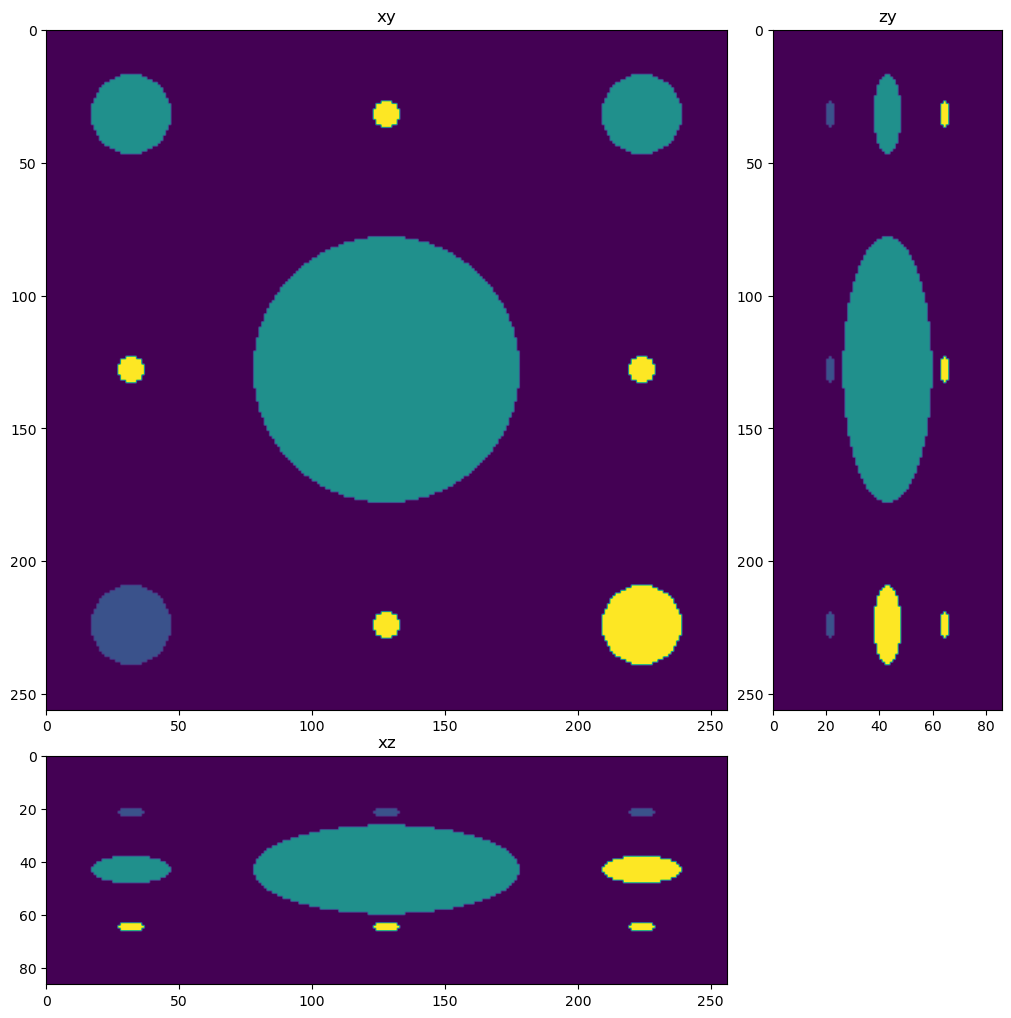

In [2]:
import raster_geometry as rg
from tnia.simulation.phantoms import add_small_to_large

gain = 400
background = 0 

zdim = 256
ydim = 256
xdim = 256

phantom = np.zeros((zdim,ydim,xdim), dtype=np.float32)

r=50
r_small=5
r_medium=15
size = [2*r, 2*r, 2*r]
size_small = [2*r_small, 2*r_small, 2*r_small]
size_medium = [2*r_medium, 2*r_medium, 2*r_medium]

sphere = rg.sphere(size, r).astype(np.float32)
small_sphere = rg.sphere(size_small, r_small).astype(np.float32)
medium_sphere = rg.sphere(size_medium, r_medium).astype(np.float32)

x=100
y=100
z=50


add_small_to_large(phantom, sphere, phantom.shape[2]//2, phantom.shape[1]//2, phantom.shape[0]//2)

add_small_to_large(phantom, medium_sphere, phantom.shape[2]//8, phantom.shape[1]//8, phantom.shape[0]//2)
add_small_to_large(phantom, 0.5*medium_sphere, phantom.shape[2]//8, 7*phantom.shape[1]//8, phantom.shape[0]//2)
add_small_to_large(phantom, medium_sphere, 7*phantom.shape[2]//8, phantom.shape[1]//8, phantom.shape[0]//2)
add_small_to_large(phantom, 2*medium_sphere, 7*phantom.shape[2]//8, 7*phantom.shape[1]//8, phantom.shape[0]//2)

add_small_to_large(phantom, small_sphere, phantom.shape[2]//8, phantom.shape[1]//2, phantom.shape[0]//2)
add_small_to_large(phantom, small_sphere, 7*phantom.shape[2]//8, phantom.shape[1]//2, phantom.shape[0]//2)
add_small_to_large(phantom, small_sphere, phantom.shape[2]//2, phantom.shape[1]//8, phantom.shape[0]//2)
add_small_to_large(phantom, small_sphere, phantom.shape[2]//2, 7*phantom.shape[1]//8, phantom.shape[0]//2)

add_small_to_large(phantom, 0.5*small_sphere, phantom.shape[2]//8, phantom.shape[1]//2, phantom.shape[0]//4)
add_small_to_large(phantom, 0.5*small_sphere, 7*phantom.shape[2]//8, phantom.shape[1]//2, phantom.shape[0]//4)
add_small_to_large(phantom, 0.5*small_sphere, phantom.shape[2]//2, phantom.shape[1]//8, phantom.shape[0]//4)
add_small_to_large(phantom, 0.5*small_sphere, phantom.shape[2]//2, 7*phantom.shape[1]//8, phantom.shape[0]//4)

add_small_to_large(phantom, 2*small_sphere, phantom.shape[2]//8, phantom.shape[1]//2, 3*phantom.shape[0]//4)
add_small_to_large(phantom, 2*small_sphere, 7*phantom.shape[2]//8, phantom.shape[1]//2, 3*phantom.shape[0]//4)
add_small_to_large(phantom, 2*small_sphere, phantom.shape[2]//2, phantom.shape[1]//8, 3*phantom.shape[0]//4)
add_small_to_large(phantom, 2*small_sphere, phantom.shape[2]//2, 7*phantom.shape[1]//8, 3*phantom.shape[0]//4)

phantom = phantom[::3,:,:]
phantom = phantom*gain

fig = show_xyz_max(phantom)

## Create the forward PSF and deconvolution PSF

Note that the forward PSF (the PSF that explains the image) is not equal to the digital PSF used for deconvolution.  Among other imperfect approximations the PSF used for deconvolution can have smaller spatial extent.  In this simulation the PSF we use for convolution (ie in the simulation) is different than the PSF used for deconvolution.  We can change the parameters of the deconvolution PSF to study how differences between the real PSF and the digital PSF we use for deconvolution affects the result. 

Two factors which are important but may also be only approximately known are the refractive index of the biological sample and the depth of the sample (below the cover lens).  These two factors combine to produce spherical aberration in the PSF.

If there is aberration in the true PSF of the system, to get a good deconvololution result that aberration must be matched in the sample. 

In [3]:
phantom.shape

(86, 256, 256)

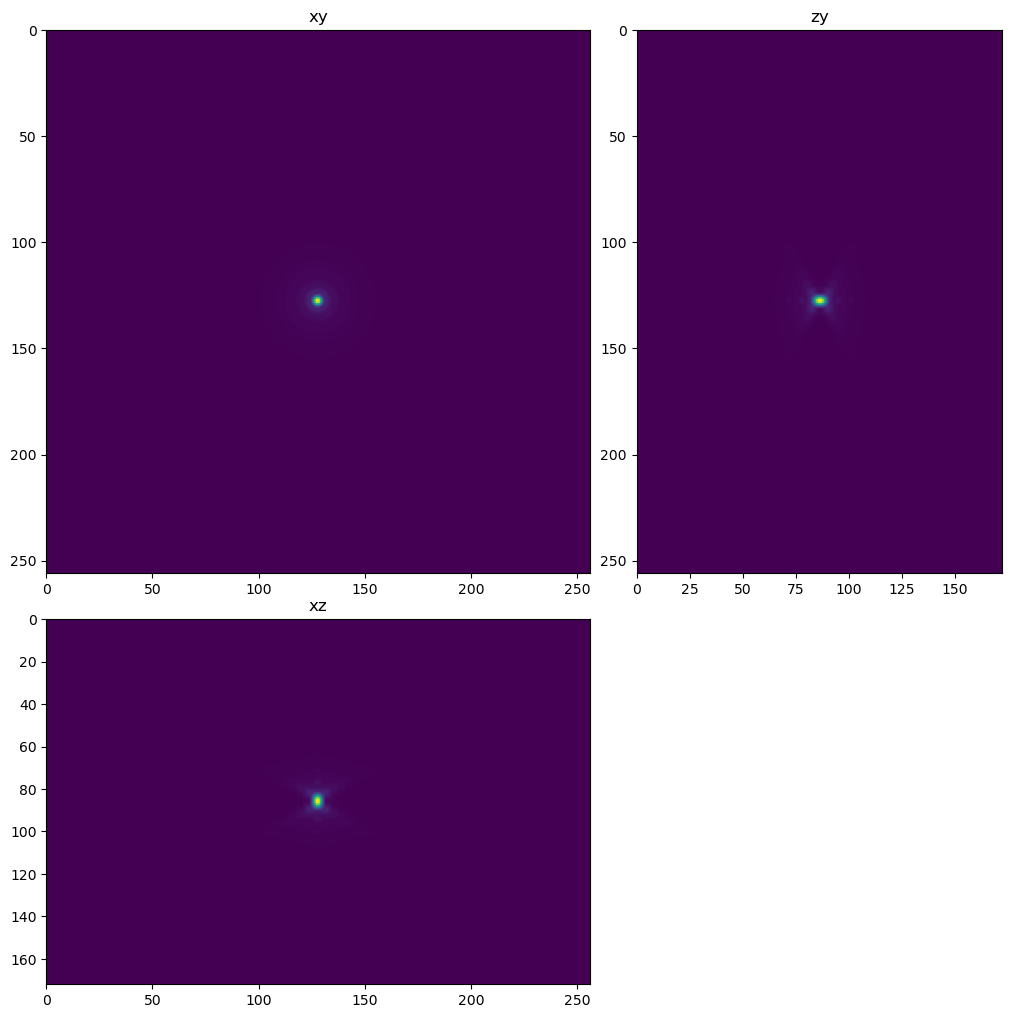

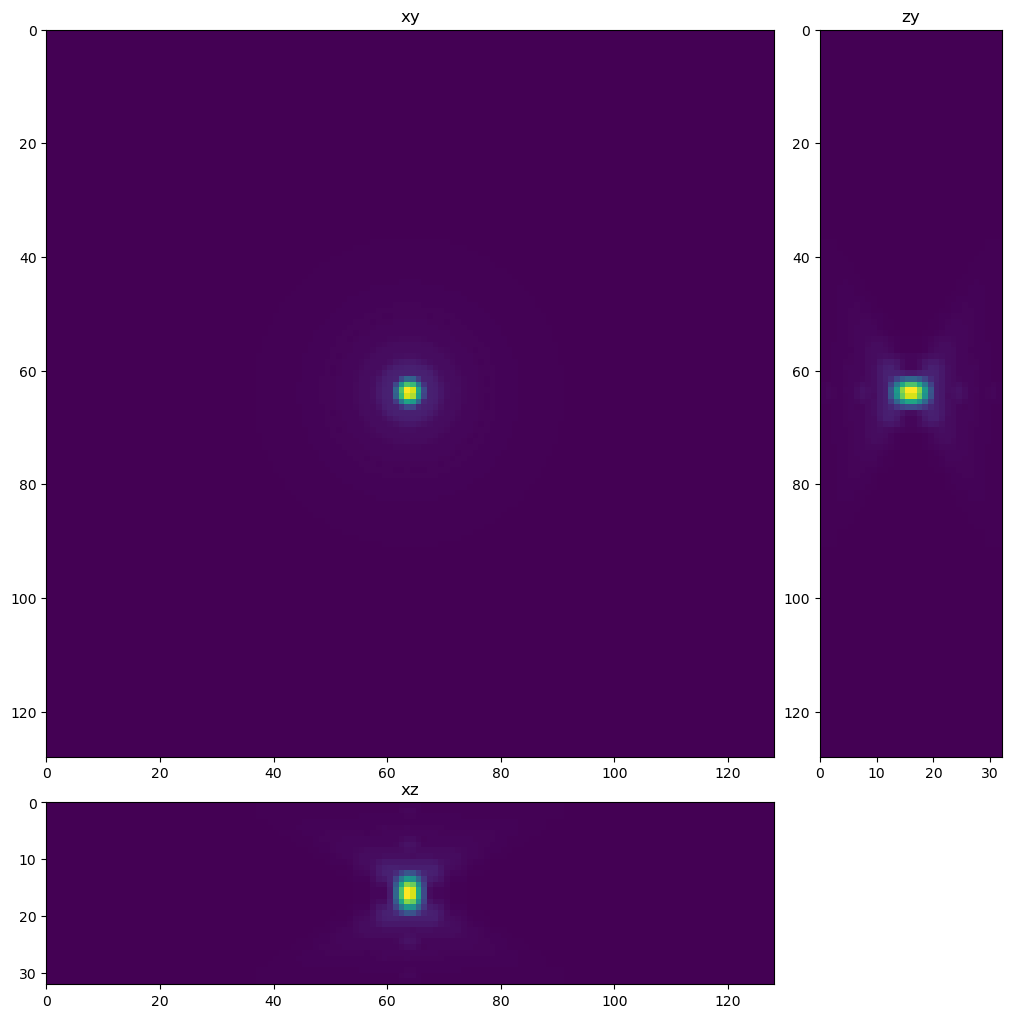

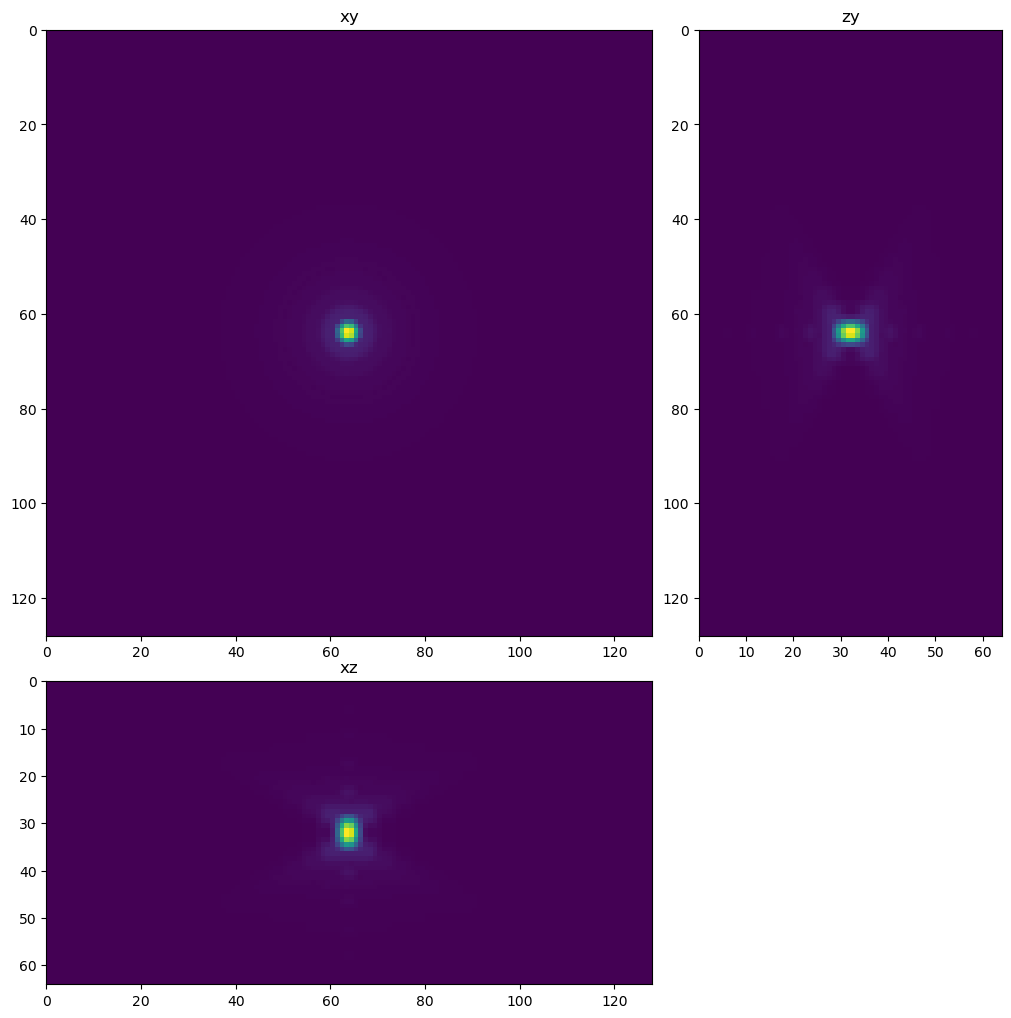

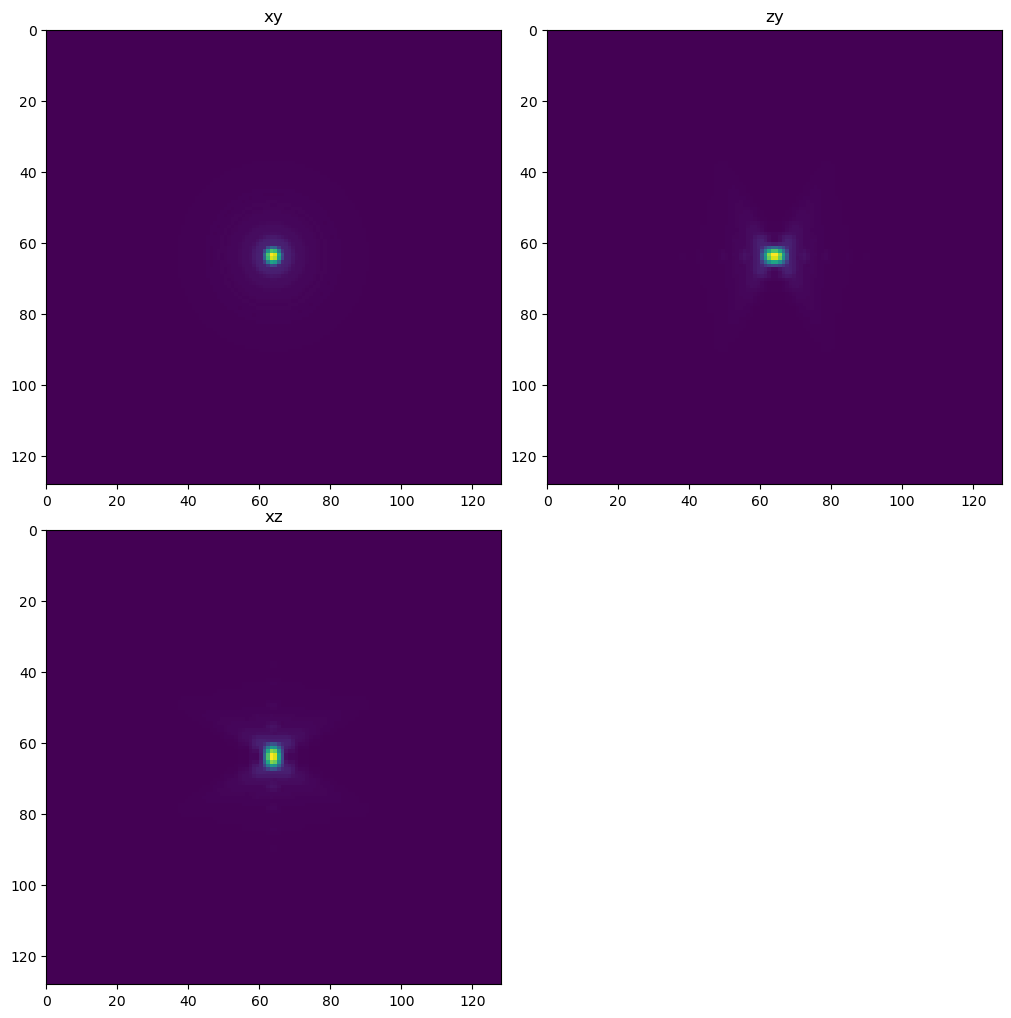

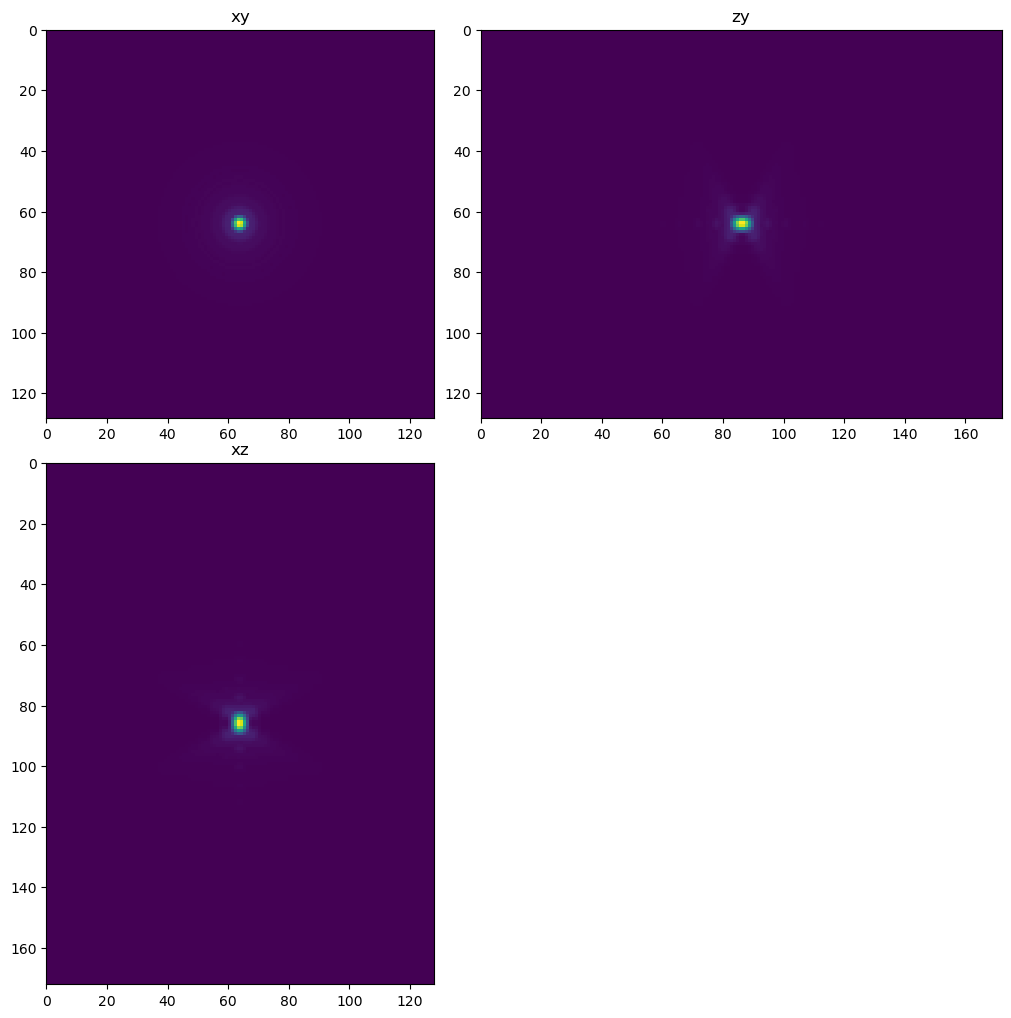

In [4]:
from tnia.deconvolution.psfs import gibson_lanni_3D

x_voxel_size = 0.1
z_voxel_size=0.3

sxy = 1
sz = z_voxel_size/x_voxel_size

xy_psf_dim_forward=phantom.shape[1]
z_psf_dim_forward=phantom.shape[0]*2

NA=0.7

# ni is the refractive index of the immersion medium of the lens
ni=1
# ns is the refractive index of the sample
ns=1.33

# depth at which to calculate the PSF (note if there is a RI mismatch between the lens RI and sample RI spherical aberration will be introduced
# which will be depth dependent)
#depth_forward = 10
depth_forward = 0
depth_decon = 0 

psf_forward  = gibson_lanni_3D(NA, ni, ns, x_voxel_size, z_voxel_size, xy_psf_dim_forward, z_psf_dim_forward, depth_forward, 0.5, False, True)
psf_forward = psf_forward.astype('float32')
psf_forward = psf_forward/psf_forward.sum()

fig = show_xyz_max(psf_forward)

psf_decons_sizes = [(128, 32), (128, 64), (128,128), (128,phantom.shape[0]*2)]
psfs = []
for s in psf_decons_sizes:
    psf=gibson_lanni_3D(NA, ni, ns, x_voxel_size, z_voxel_size, s[0], s[1], depth_decon, 0.5, False, True)
    psf = psf.astype('float32')
    psf = psf/psf.sum()
    psfs.append(psf)
    fig = show_xyz_max(psf)

## Apply the forward model

In this case the forward model is convolution with the PSF and the addition of Poisson noise.  

What other factors will cause error between the true shape of the sample and the acquired image? 

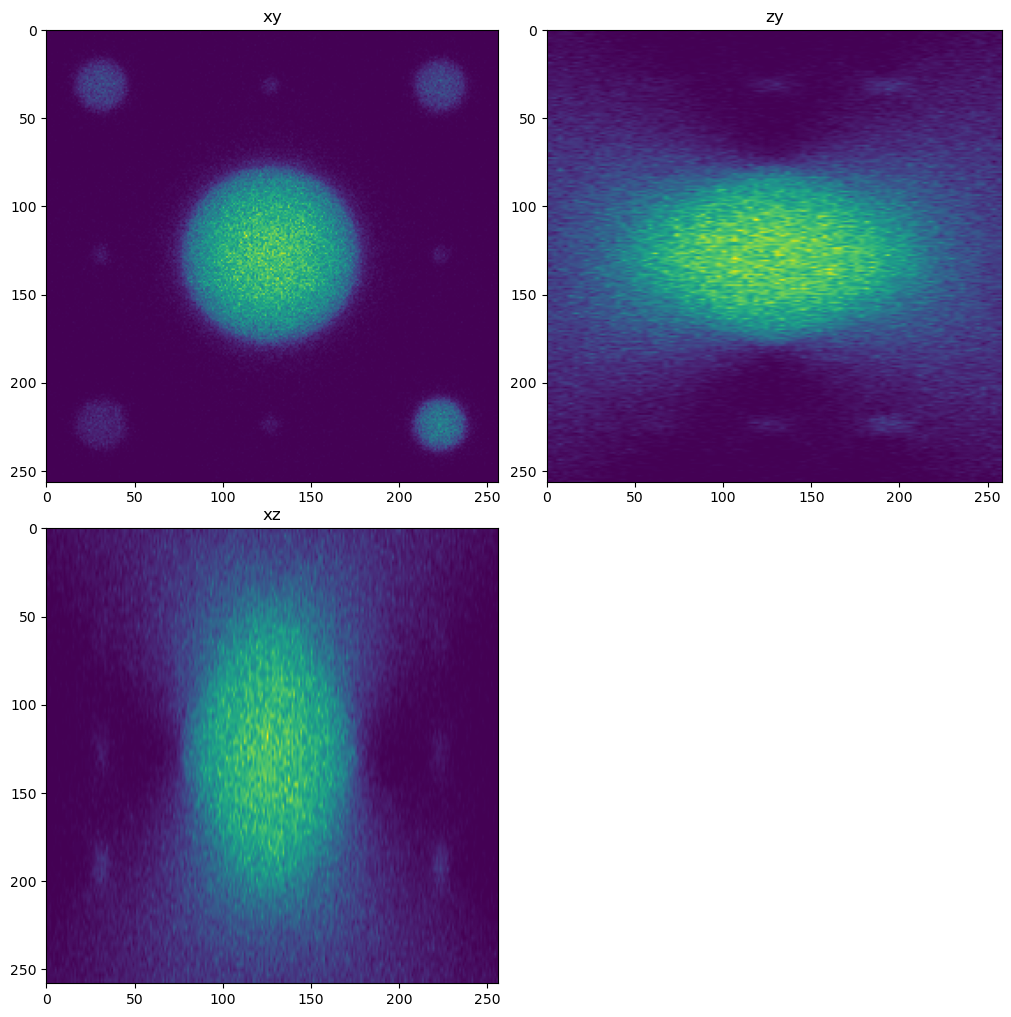

In [5]:
from tnia.deconvolution.forward import forward
from tnia.nd.ndutil import centercrop

im = forward(phantom, psf_forward, background, True, True)

x_v = im.shape[2]//2
y_v = im.shape[1]//2
z_v = im.shape[0]//2

phantom=phantom+background

fig = show_xyz_slice(im, x_v, y_v, z_v, sxy=sxy, sz=sz)

In [6]:
from clij2fft.richardson_lucy import richardson_lucy_nc 

## Deconvolve with the different PSFs

In [7]:
decons = []

for psf in psfs:
    decon = richardson_lucy_nc(im, psf, 500, 0.001)
    decons.append(decon)

get lib
calling convcorr 0 0
get lib
calling convcorr 0 0
get lib
calling convcorr 0 0
get lib
calling convcorr 0 0


In [8]:
import napari
viewer = napari.Viewer()
viewer.add_image(phantom)
viewer.add_image(im)
for d in decons:
    viewer.add_image(d)

napari.manifest -> 'napari-hello' could not be imported: Cannot find module 'napari_plugins' declared in entrypoint: 'napari_plugins:napari.yaml'


In [18]:
imsave('../../data/deep learning testing/deconvolutions/spheres4.tif', decon2)

## Look at error

In [26]:
from tnia.metrics.errors import RMSE

print('RMSE (phantom, phantom)', RMSE(phantom, phantom))
print('RMSE (phantom, im)', RMSE(phantom, im))
print('RMSE (phantom, decon 1)', RMSE(phantom, decon1))
print('RMSE (phantom, decon 2)', RMSE(phantom, decon2))
print('RMSE (phantom, decon 2)', RMSE(phantom, decon3))

RMSE (phantom, phantom) 0.0
RMSE (phantom, im) 30.723381
RMSE (phantom, decon 1) 19.446545
RMSE (phantom, decon 2) 8.819286
RMSE (phantom, decon 2) 15.578349


## Segment the spheres

In [27]:
# import otsu
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops

def segmenter(im, min_area=0):
    
    binary = im>threshold_otsu(im)
    labels = label(binary) 
    
    # get the regions
    object_list = regionprops(labels,im)

    filtered_objects = []
    labels_filtered = np.zeros_like(labels)

    if min_area==0:
        return object_list, labels
    
    else:
        for obj in object_list:
            
            if obj.area > min_area:
                labels_filtered[labels==obj.label]=obj.label
                filtered_objects.append(obj)
        return filtered_objects, labels_filtered

In [28]:
objects_truth, labels_truth = segmenter(phantom, 20)
objects_im, labels_im = segmenter(im, 20)
objects_decon1, labels_decon1 = segmenter(decon1, 20)
objects_decon2, labels_decon2 = segmenter(decon2, 20)

print('objects_truth', len(objects_truth))
print('objects_im', len(objects_im))
print('objects_decon', len(objects_decon1))
print('objects_decon', len(objects_decon2))


objects_truth 12
objects_im 11
objects_decon 12
objects_decon 12


## Make figures of segmentations

In [29]:
from tnia.plotting.projections import show_xy_xz_slice
from tnia.plotting.projections import show_xy_xz
from matplotlib import pyplot as plt

from tnia.plotting.projections import show_xy_zy_slice
from tnia.plotting.plt_helper import random_label_cmap

def makefigs():
    fig1=show_xy_xz_slice(labels_im, x_v, y_v, z_v, sxy=sxy, sz=sz,figsize=(4,9), colormap=random_label_cmap())
    fig1.suptitle('Segmentation of image')
    fig2=show_xy_xz_slice(labels_decon1, x_v, y_v, z_v, sxy=sxy, sz=sz,figsize=(4,9), colormap=random_label_cmap())
    fig2.suptitle('Segmentation of 50 iterations of RL')
    fig3=show_xy_xz_slice(labels_decon2, x_v, y_v, z_v, sxy=sxy, sz=sz,figsize=(4,9), colormap=random_label_cmap())
    fig3.suptitle('Segmentation of 500 iterations of RL')
    fig1.savefig('labels_im.png')
    fig2.savefig('labels_decon1.png')
    fig3.savefig('labels_decon2.png')
    plt.close(fig1)
    plt.close(fig2)
    plt.close(fig3)

makefigs()



## Segmentation results

It was a bit tricky to get side by side XY/XZ views of the results (this is the most space efficient means to view the images).  By default new images seem to be rendered below the previous one in notebooks.  So we saved the projection as .png files then used some html to render them (double click on this cell to see the html)

<div>
    <img src="labels_im.png?version=foo" width="300">
    <img src="labels_decon1.png?version=foo2" width="300">
    <img src="labels_decon2.png?version=foo3" width="300">
</div>

In [30]:
#  print size and intensity of each object
for obj in objects_truth:
    # if object index is not 0
    if obj.label != 1:
        print('truth', obj.area, obj.mean_intensity)

print()

for obj in objects_im:
    if obj.label != 1:
        print('im', obj.area, obj.mean_intensity)

print()

for obj in objects_decon1:
    if obj.label != 1:
        print('decon 1', obj.area, obj.mean_intensity)

print()

for obj in objects_decon2:
    if obj.label != 1:
        print('decon 2', obj.area, obj.mean_intensity)
    

truth 4808.0 400.0
truth 4808.0 400.0
truth 4808.0 800.0
truth 184.0 400.0
truth 184.0 400.0
truth 184.0 400.0
truth 184.0 400.0
truth 184.0 800.0
truth 184.0 800.0
truth 184.0 800.0
truth 184.0 800.0

im 20188.0 36.814495
im 8216.0 29.10151
im 8234.0 29.159096
im 8242.0 29.066124
im 2777.0 20.8556
im 24.0 18.041666
im 24.0 19.458334
im 188.0 23.25
im 190.0 23.252632
im 188.0 22.898935
im 191.0 23.193718

decon 1 3742.0 202.43048
decon 1 4772.0 358.0622
decon 1 3693.0 203.58267
decon 1 3702.0 205.78873
decon 1 123.0 175.05252
decon 1 122.0 181.13115
decon 1 129.0 167.46465
decon 1 112.0 186.98088
decon 1 182.0 299.51242
decon 1 186.0 297.67642
decon 1 182.0 296.65033
decon 1 185.0 294.5496

decon 2 4070.0 394.58322
decon 2 4149.0 389.82193
decon 2 4939.0 716.7416
decon 2 139.0 349.4085
decon 2 144.0 353.98645
decon 2 140.0 359.48877
decon 2 159.0 327.10516
decon 2 190.0 639.8806
decon 2 203.0 613.69696
decon 2 193.0 637.5009
decon 2 192.0 637.8118


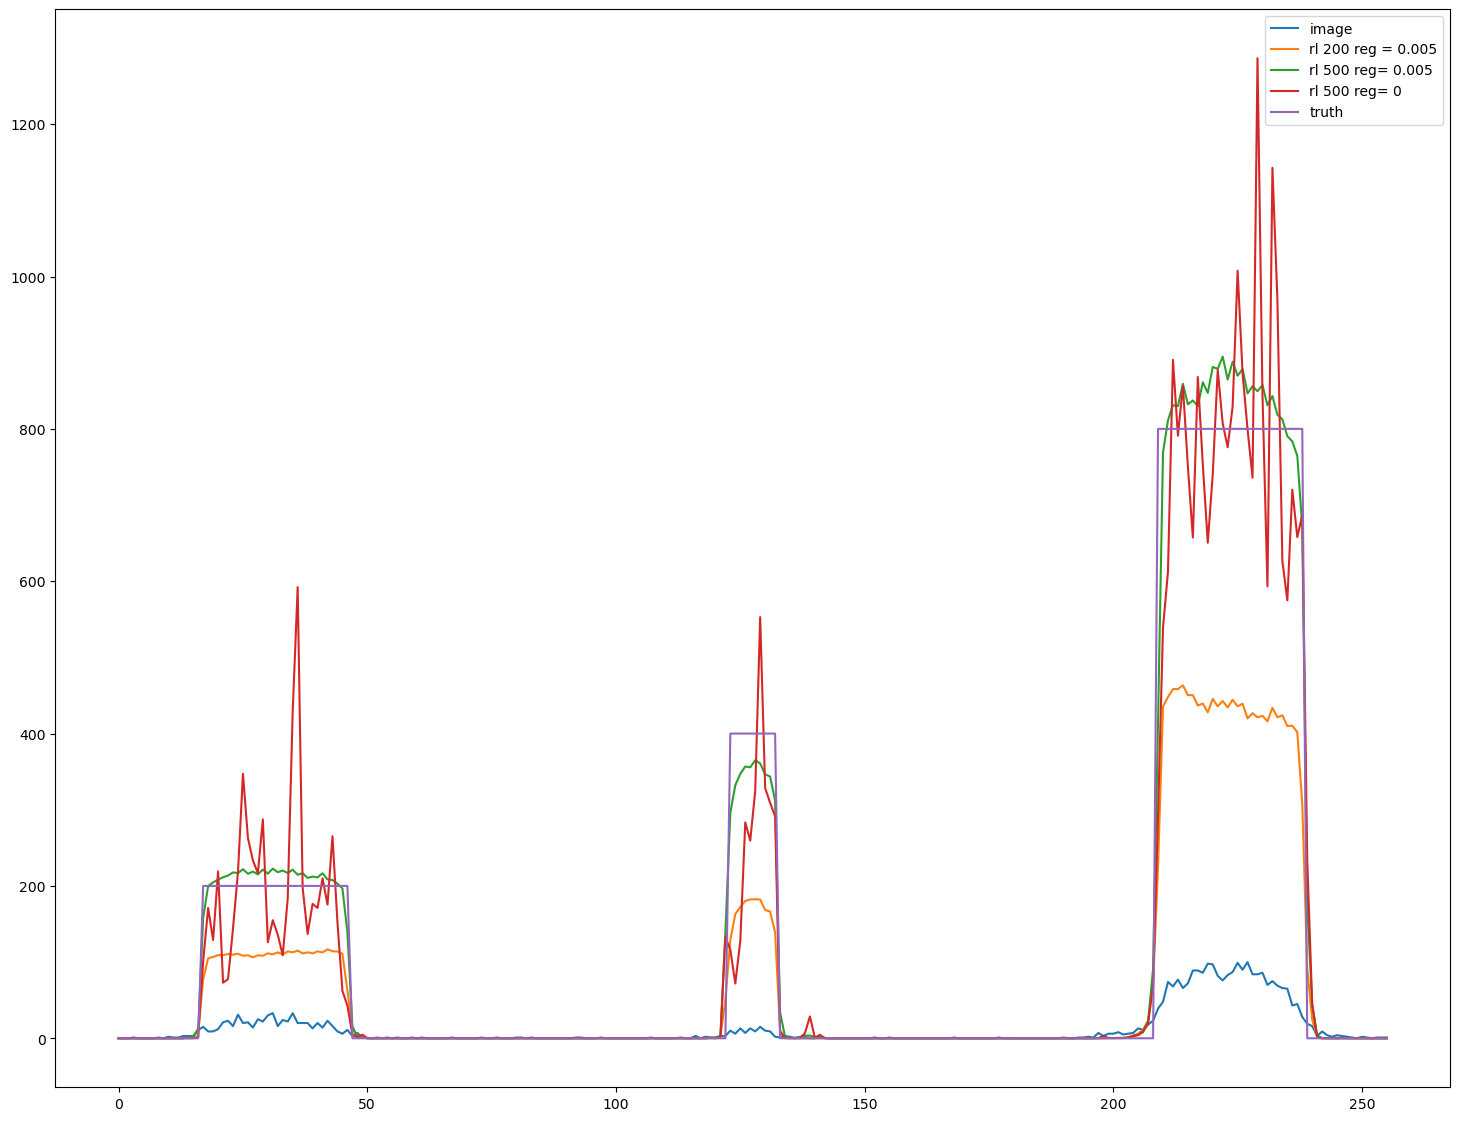

In [31]:
import matplotlib.pyplot as plt
s=im.shape

fig, ax = plt.subplots(figsize=(18,14))

line_z=int(s[0]//2)
line_y=int(7*s[1]//8)

line=im[line_z,line_y,:]
ax.plot(line, label = 'image')

line=decon1[line_z,line_y,:]
ax.plot(line, label='rl '+'200 reg = 0.005')

line=decon2[line_z,line_y,:]
ax.plot(line, label='rl '+'500 reg= 0.005')

line=decon3[line_z,line_y,:]
ax.plot(line, label='rl '+'500 reg= 0')

line=phantom[line_z,line_y,:]
ax.plot(line, label='truth')

ax.legend()

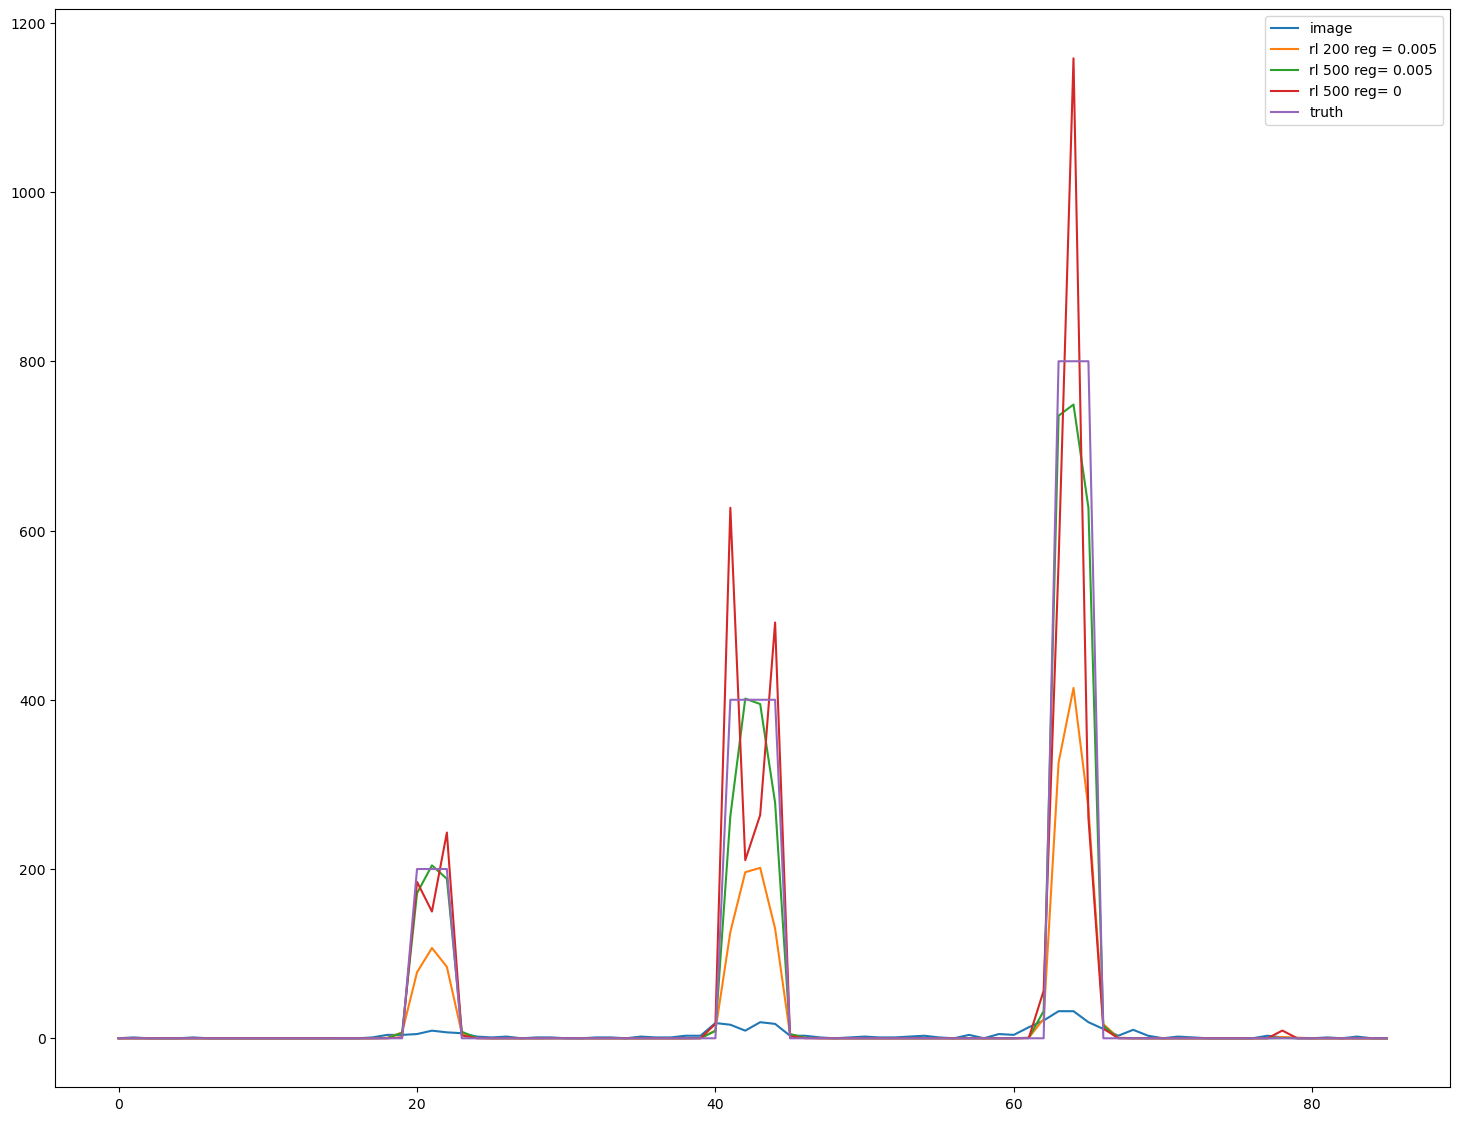

In [32]:
import matplotlib.pyplot as plt
s=im.shape

fig, ax = plt.subplots(figsize=(18,14))

line_y=int(s[1]//2)
line_x=int(s[1]//8)

line=im[:,line_y,line_x]
ax.plot(line, label = 'image')

line=decon1[:,line_y,line_x]
ax.plot(line, label='rl '+'200 reg = 0.005')

line=decon2[:,line_y,line_x]
ax.plot(line, label='rl '+'500 reg= 0.005')

line=decon3[:,line_y,line_x]
ax.plot(line, label='rl '+'500 reg= 0')

line=phantom[:,line_y,line_x]
ax.plot(line, label='truth')

ax.legend()

# View in Napari

In [36]:
import napari
viewer = napari.Viewer()
viewer.add_image(phantom, scale=[3,1,1],name='phantom')
viewer.add_image(im, scale=[3,1,1],name='im')
viewer.add_image(decon1, scale=[3,1,1],name='decon 1')
viewer.add_image(decon2, scale=[3,1,1],name='decon 2')
viewer.add_labels(labels_im, scale=[3,1,1],name='labels_im')
viewer.add_labels(labels_decon1, scale=[3,1,1],name='labels_decon 1')
viewer.add_labels(labels_decon2, scale=[3,1,1],name='labels_decon 2')


<Labels layer 'labels_decon 2' at 0x2c885f113a0>